
Model 2: Transfer learning

In [ ]:
# import os
# import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.image import imread
# import cv2
# from plotly import express as px
# import plotly.io as pio
# import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

In [ ]:
# split the stanford_dogs data
(train_dataset, validation_dataset, test_dataset), metadata = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteS1JH4J/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteS1JH4J/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
# batch size
BATCH_SIZE = 32
# standard image size
IMG_SIZE = (299, 299)

In [ ]:
# Dog breeds number
num_classes = metadata.features['label'].num_classes

In [ ]:
# resize images to a fixed image size(299 x 299)
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
validation_dataset = validation_dataset.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
test_dataset = test_dataset.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))

In [ ]:
# normalize pixel values to [-1,1]
def preprocessor(images, labels):
  return tf.keras.applications.xception.preprocess_input(images), labels

train_dataset = train_dataset.map(preprocessor)
validation_dataset = validation_dataset.map(preprocessor)
test_dataset = test_dataset.map(preprocessor)

In [ ]:
# number of data to take each time 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=10)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=10)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=10)

In [ ]:
# create a base model using xception
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet')

# Freeze the base_model
base_model.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# https://keras.io/api/applications/

# add layers on base model's output
x = base_model.output
# augmentation layer 
x = tf.keras.layers.RandomFlip("horizontal")(x)
# augmentation layer 
x = tf.keras.layers.RandomRotation(0.2)(x)
# additional layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Dropout layer to reduce overfitting
x = tf.keras.layers.Dropout(0.2)(x)
# Dense layer to have 120 outputs
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Use Model model
model2 = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_dataset,
                      epochs=10,
                      validation_data=validation_dataset)

Epoch 1/10
300/300 [==============================] - 192s 593ms/step - loss: 3.7224 - accuracy: 0.4983 - val_loss: 2.7615 - val_accuracy: 0.8442
Epoch 2/10
300/300 [==============================] - 176s 587ms/step - loss: 2.0233 - accuracy: 0.8658 - val_loss: 1.5317 - val_accuracy: 0.8958
Epoch 3/10
300/300 [==============================] - 176s 587ms/step - loss: 1.1533 - accuracy: 0.8947 - val_loss: 0.9694 - val_accuracy: 0.9092
Epoch 4/10
300/300 [==============================] - 176s 586ms/step - loss: 0.7738 - accuracy: 0.9047 - val_loss: 0.7120 - val_accuracy: 0.9183
Epoch 5/10
300/300 [==============================] - 176s 586ms/step - loss: 0.5935 - accuracy: 0.9126 - val_loss: 0.5751 - val_accuracy: 0.9183
Epoch 6/10
300/300 [==============================] - 176s 586ms/step - loss: 0.4898 - accuracy: 0.9152 - val_loss: 0.4931 - val_accuracy: 0.9217
Epoch 7/10
300/300 [==============================] - 176s 586ms/step - loss: 0.4259 - accuracy: 0.9187 - val_loss: 0.4390 -

In [ ]:
model2.evaluate(test_dataset)

38/38 [==============================] - 19s 507ms/step - loss: 0.3667 - accuracy: 0.9117


[0.3667178452014923, 0.9116666913032532]

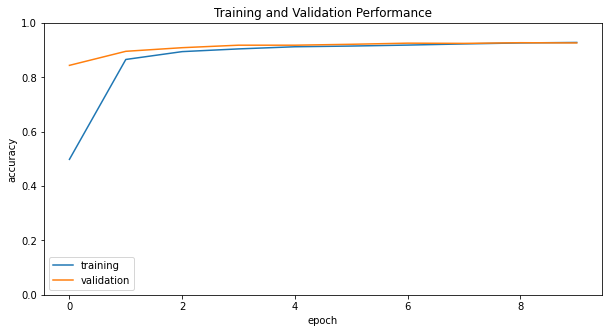

In [ ]:
# plot of accuracy
plt.figure(figsize=(10,5))
plt.plot(history2.history["accuracy"], label = "training")
plt.plot(history2.history["val_accuracy"], label = "validation")
plt.ylim([0,1])
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.title("Training and Validation Performance")
plt.legend()

In [ ]:
model2.save('/content/model2.h5')

[[5.48742653e-04 5.93619443e-05 5.47019117e-05 1.62318960e-04
  1.08115470e-04 7.19636446e-05 2.14673873e-05 9.30408423e-04
  4.16108887e-05 4.24099526e-05 1.50883076e-04 2.95457103e-05
  3.67305911e-05 1.13353044e-05 8.22255515e-06 2.66595853e-05
  1.48115278e-05 3.25714900e-05 2.35005828e-05 5.26898111e-05
  9.76182200e-05 1.02814061e-04 1.85797508e-05 3.58194848e-05
  5.08410521e-05 1.09143502e-05 6.55063413e-05 6.03055487e-05
  1.39077310e-03 6.84075058e-04 4.17472729e-05 1.52370794e-05
  3.57066965e-05 4.03605518e-05 3.24702014e-05 1.53677131e-04
  7.32019689e-05 4.35766233e-05 9.99910262e-05 4.14889655e-05
  4.46783415e-05 6.13737575e-05 6.59573707e-05 4.22360317e-05
  6.73982035e-03 6.63233950e-05 5.89843548e-05 6.81169258e-05
  1.07404318e-04 4.45546975e-05 9.32602125e-05 4.75681081e-05
  1.21269994e-04 5.60506414e-05 3.18288403e-05 5.98769075e-05
  3.21115076e-05 7.61426199e-05 5.14308376e-05 5.00071728e-05
  2.98237082e-05 2.37059194e-05 6.05356981e-05 2.15412783e-05
  1.1147

'n02108915-french_bulldog'

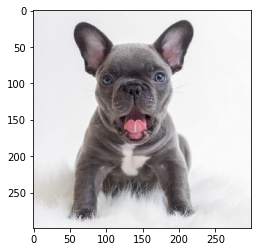

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np


classes = metadata.features['label'].names

img_width, img_height = 299, 299

# predicting images
img = image.load_img('/content/il_1588xN.2766222350_3tk8.jpg', target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)/255.

# Get predicted probabilities for 120 class labels
pred_classes = model2.predict(x, batch_size=32)
print(pred_classes)

# Display image being classified
plt.imshow(img)
get = np.argsort(pred_classes)
get=get[0]
print(get[-1:-6:-1])

# Get index of highest probability and use it to get class label
classes[np.argmax(pred_classes)]

[[1.36039150e-03 3.65595843e-05 6.13616733e-03 9.48674395e-04
  3.17503023e-03 2.56337924e-04 8.61785738e-05 2.43516499e-03
  2.09608072e-04 8.17307809e-05 1.19939803e-04 2.72441772e-04
  7.98993424e-05 7.52204287e-05 9.69844186e-05 1.79585360e-04
  4.83575677e-05 6.08322327e-04 3.16053338e-05 1.90487626e-05
  4.78816015e-04 3.34605371e-04 3.49730108e-05 2.22756251e-04
  3.70531052e-04 1.51704458e-04 6.15962199e-05 1.82596355e-04
  7.99319649e-04 2.74108432e-04 7.66231213e-04 1.70082349e-04
  2.67990166e-04 3.70410224e-03 5.27244154e-03 4.04367782e-03
  2.33123396e-02 4.27447725e-03 3.91971841e-02 1.84165052e-04
  1.11778919e-02 6.28798385e-04 1.93307467e-03 2.98144907e-04
  2.88555835e-04 1.13204122e-03 3.22833293e-05 1.22568934e-04
  8.36724066e-04 1.71187596e-04 1.04487268e-03 5.75709902e-03
  6.22774940e-03 2.63987249e-03 5.41287845e-05 7.65580451e-04
  8.63301393e-04 5.77756553e-04 3.79450386e-04 9.11270326e-05
  2.23102994e-04 5.44699396e-05 7.06104795e-04 1.21459554e-04
  4.1270

'n02113624-toy_poodle'

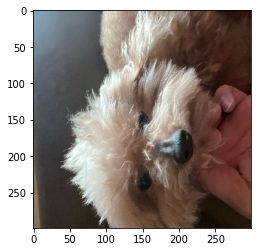

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np


classes = metadata.features['label'].names

img_width, img_height = 299, 299

# predicting images
img = image.load_img('/content/13421646552325.jpg', target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)/255.

# Get predicted probabilities for 120 class labels
pred_classes = model2.predict(x, batch_size=32)
print(pred_classes)

# Display image being classified
plt.imshow(img)
get = np.argsort(pred_classes)
get=get[0]
print(get[-1:-6:-1])

# Get index of highest probability and use it to get class label
classes[np.argmax(pred_classes)]

# Model 2

In this model, we're still using the transfer learning method. But we apply the `keras.Model` instead. Similar to the model 1, we still need to standardize images' sizes to 299 * 299 and also normalize the pixel values to [-1,1] before we use it. The difference is this time we slightly change the method during normalizing the pixel values, but the idea is still the same. After cleaning up the dataset, we build a base model using the xception application. Next, we add layers to the base model's output. The layers that we added include the two Augmentation layers(modify copies of images), a GlobalAveragePooling2D layer, a Dropout layer(reduce overfitting), and a Dense layer(having the same outputs as the number of dog breeds). To build our model, we use keras.Model to create where inputs is the base model's input and the outputs is the chain layers applied on the base model's output. After a few tests, we decide to use the learning-rate value with 0.0001 and the epochs with 10. By observing the history2, the model is slightly overfitting on the training data. And the difference between accuracy valued and validating value is about 7%. Even though the model is overfitting, we still want to test how well it predicts our uploading images. First, we upload the same French-bull dog image as we did on the Model1. By looking at the result, it shows the top possibily dog breed is exactly the French-bull dog!! And the top 5 dog breeds also has a super relative looking as the French-bull dog!!! It seems like the model does pretty well. To double check, we tried one more test, which is a single Toy poodle. Luckily, the model predicts that it's toy poodle!! 

Comparing Model1 and Model2, both of them have an overfitting issue. But look at the result of the predictions, the Model2 well performs than Model1. Therefore, we decide to use Model2 in our project.